In [6]:
import itertools
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import joblib

In [7]:
df = pd.read_csv('/Users/hwangtaeeon/Documents/GitHub/Data-AI/Care_Duration_Prediction_Model/Data_Preprocessing/Regular_Expression/final_data.csv')

# 고유 병명 리스트
diseases = df['병명'].tolist()

# 각 특성별 범주 정의
genders = ['성별_남자', '성별_여자']
surgery_status = ['수술여부_아니오', '수술여부_예']
age_groups = ['연령대_30세미만', '연령대_30-39세', '연령대_40-49세', '연령대_50-59세', '연령대_60세이상']
regions = ['지역본부_서울지역', '지역본부_부산지역', '지역본부_대구지역', '지역본부_경인지역', '지역본부_광주지역', '지역본부_대전지역']

In [8]:
# 모든 조합 생성 (병명 포함 총 5개의 입력)
input_combinations = list(itertools.product(diseases, genders, surgery_status, age_groups, regions))

# 전처리된 데이터를 저장할 리스트
processed_data = []

# 조합마다 평균 예측값 계산
for disease, gender, surgery, age, region in input_combinations:
    row = df[df['병명'] == disease]
    if row.empty:
        continue
    values = row[[gender, surgery, age, region]].values[0]
    if pd.isnull(values).any():
        continue  # 결측값 포함 시 제외
    mean_value = values.mean()
    processed_data.append([disease, gender, surgery, age, region, mean_value])

# 데이터프레임으로 변환
processed_df = pd.DataFrame(processed_data, columns=['병명', '성별', '수술여부', '연령대', '지역본부', '예측값'])

processed_df.to_csv('processed_prediction_data.csv', index=False)

In [9]:
# 📌 Label Encoding
encoders = {}
X = pd.DataFrame()
for col in ['병명', '성별', '수술여부', '연령대', '지역본부']:
    enc = LabelEncoder()
    X[col] = enc.fit_transform(processed_df[col])
    encoders[col] = enc

y = processed_df['예측값'].values

In [10]:
# 📌 Stratified split
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, stratify=X['병명'], random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2, stratify=X_trainval['병명'], random_state=42)

In [11]:
# 📌 TensorDataset
def to_tensor(x, y):
    return TensorDataset(torch.tensor(x.values, dtype=torch.long), torch.tensor(y, dtype=torch.float32))

train_loader = DataLoader(to_tensor(X_train, y_train), batch_size=64, shuffle=True)
val_loader = DataLoader(to_tensor(X_val, y_val), batch_size=64)
test_loader = DataLoader(to_tensor(X_test, y_test), batch_size=64)

In [12]:
# 📌 MLP Model
class MLPRegressor(nn.Module):
    def __init__(self, input_dims, embed_dim=8):
        super().__init__()
        self.embeds = nn.ModuleList([
            nn.Embedding(dim, embed_dim) for dim in input_dims
        ])
        self.fc1 = nn.Linear(embed_dim * len(input_dims), 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 64)
        self.out = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.cat([emb(x[:, i]) for i, emb in enumerate(self.embeds)], dim=1)
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.fc2(x))
        return self.out(x).squeeze()

In [13]:

# 📌 Model Setup
input_dims = [X[col].nunique() for col in X.columns]
model = MLPRegressor(input_dims)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5, verbose=True)
criterion = nn.MSELoss()

/Users/hwangtaeeon/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1: train=9296.1520, val=739.4558
Epoch 2: train=582.8696, val=193.7122
Epoch 3: train=482.8909, val=220.8783
Epoch 4: train=490.0502, val=173.8118
Epoch 5: train=420.5321, val=175.4900
Epoch 6: train=431.1644, val=278.1625
Epoch 7: train=428.8192, val=264.4552
Epoch 8: train=377.5699, val=187.4351
Epoch 9: train=415.9179, val=195.4830
Epoch 10: train=437.0864, val=212.0476
Epoch 11: train=328.7339, val=145.4212
Epoch 12: train=343.5849, val=147.2778
Epoch 13: train=334.7571, val=136.4725
Epoch 14: train=340.5097, val=138.2987
Epoch 15: train=338.0596, val=146.3353
Epoch 16: train=356.9091, val=185.9816
Epoch 17: train=295.4648, val=129.2931
Epoch 18: train=336.7751, val=158.3185
Epoch 19: train=363.9743, val=147.9405
Epoch 20: train=335.4445, val=135.3714
Epoch 21: train=325.5623, val=191.1507
Epoch 22: train=312.6826, val=127.1662
Epoch 23: train=297.2830, val=173.9904
Epoch 24: train=333.0274, val=123.7503
Epoch 25: train=296.4423, val=128.7124
Epoch 26: train=359.9415, val=155

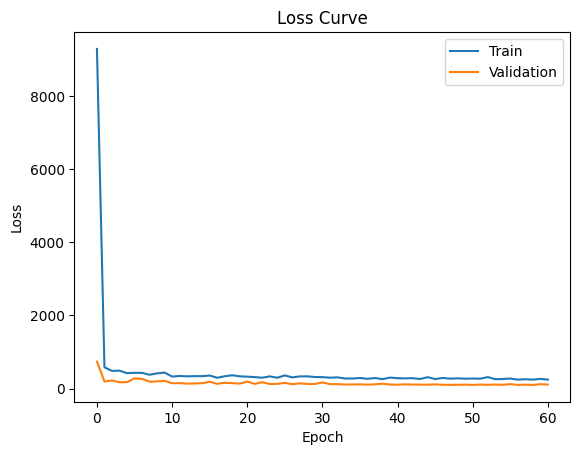

In [14]:
# 📌 Training Loop with Early Stopping
best_val_loss = float('inf')
early_stop_counter = 0
train_losses, val_losses = [], []

for epoch in range(1000):
    model.train()
    train_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * len(xb)

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            pred = model(xb)
            loss = criterion(pred, yb)
            val_loss += loss.item() * len(xb)
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)

    scheduler.step(val_loss)
    print(f"Epoch {epoch+1}: train={train_loss:.4f}, val={val_loss:.4f}")
   
    name_map = {
        '병명': 'disease',
        '성별': 'gender',
        '수술여부': 'surgery',
        '연령대': 'age',
        '지역본부': 'region'
    }
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        # 학습 후 저장 (model + encoders)
        torch.save(model.state_dict(), 'best_model.pth')
        for col, enc in encoders.items():
            eng_name = name_map[col]
            joblib.dump(enc, f'encoder_{eng_name}.pkl')
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= 10:
            print("✅ Early stopping!")
            break

# 📈 Loss Curve
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')
plt.show()

/var/folders/vw/vz_f7h9d5tzbfgcgfvhtjwzh0000gn/T/ipykernel_59194/1471704592.py:22: UserWarning: Glyph 50696 (\N{HANGUL SYLLABLE YE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/vw/vz_f7h9d5tzbfgcgfvhtjwzh0000gn/T/ipykernel_59194/1471704592.py:22: UserWarning: Glyph 52769 (\N{HANGUL SYLLABLE CEUG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/vw/vz_f7h9d5tzbfgcgfvhtjwzh0000gn/T/ipykernel_59194/1471704592.py:22: UserWarning: Glyph 44050 (\N{HANGUL SYLLABLE GABS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/hwangtaeeon/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 50696 (\N{HANGUL SYLLABLE YE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/hwangtaeeon/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 52769 (\N{HANGUL SYLLABLE CEUG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(byte

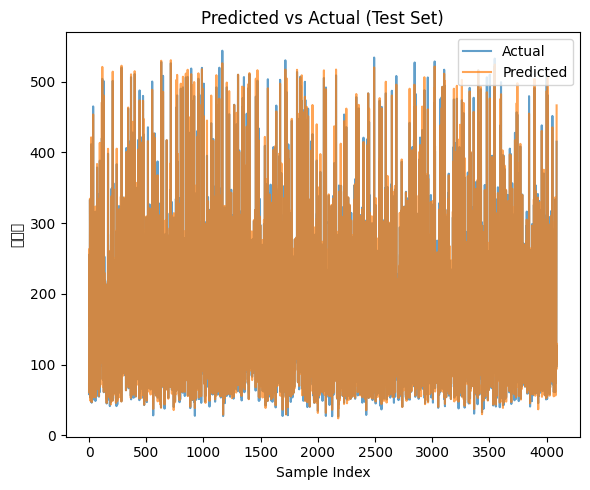

In [15]:
# 📌 Test Set Evaluation & Visualization
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

predictions = []
actuals = []

with torch.no_grad():
    for xb, yb in test_loader:
        pred = model(xb)
        predictions.extend(pred.tolist())
        actuals.extend(yb.tolist())

# 📈 예측값 vs 실제값 시각화
plt.figure(figsize=(6, 5))
plt.plot(actuals, label='Actual', alpha=0.7)
plt.plot(predictions, label='Predicted', alpha=0.7)
plt.title('Predicted vs Actual (Test Set)')
plt.xlabel('Sample Index')
plt.ylabel('예측값')
plt.legend()
plt.tight_layout()
plt.show()

In [16]:
def predict_care_duration(disease, gender, surgery, age_group, region, model, encoders):
    model.eval()

    # 입력값을 DataFrame 형식으로 정리
    input_dict = {
        '병명': [disease],
        '성별': [gender],
        '수술여부': [surgery],
        '연령대': [age_group],
        '지역본부': [region]
    }
    input_df = pd.DataFrame(input_dict)

    # 라벨 인코딩
    for col in input_df.columns:
        if col in encoders:
            input_df[col] = encoders[col].transform(input_df[col])

    # 텐서 변환
    input_tensor = torch.tensor(input_df.values, dtype=torch.long)

    # 예측
    with torch.no_grad():
        pred = model(input_tensor)
        return pred.item()

# 모델 정의와 로딩
input_dims = [X[col].nunique() for col in X.columns]
model = MLPRegressor(input_dims)
model.load_state_dict(torch.load('best_model.pth'))

# 예시 입력
disease = 'S000(머리덮개의 얕은 손상)'  # 병명은 학습 시 사용된 disease 중 하나여야 함
gender = '성별_남자'
surgery = '수술여부_아니오'
age_group = '연령대_50-59세'
region = '지역본부_서울지역'

# 예측 수행
predicted_value = predict_care_duration(disease, gender, surgery, age_group, region, model, encoders)
print(f"📌 예측된 요양일: {predicted_value:.2f}일")


📌 예측된 요양일: 62.80일
